In [1]:
%matplotlib inline
!pip install plotly
!pip install yahoo_fin
import pandas as pd
import numpy as np
import seaborn as sns # !
import matplotlib.pyplot as plt # !
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
import plotly.express as px
from yahoo_fin.stock_info import get_data
from google.colab import drive
import requests
from datetime import datetime, date, timedelta

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import gradient_descent_v2 #SGD
import math
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

sgd = gradient_descent_v2.SGD(...)

mergers = pd.read_csv('https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/merger_spacs.csv')
pending_mergers =  pd.read_csv('https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/pending_spac_mergers.csv')

# some additional settings for sns
sns.set()
sns.set(rc={"figure.figsize": (20, 10)})
PALETTE = sns.color_palette('deep', n_colors=3) # will be used for cmap which is a parameter of seaborn scatter
CMAP = ListedColormap(PALETTE.as_hex()) # A Colormap instance or registered colormap name. cmap is only used if c is an array of floats.
RANDOM_STATE = 42

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 7.0 MB/s 
     |████████████████████████████████| 83 kB 2.0 MB/s 
     |████████████████████████████████| 112 kB 55.2 MB/s 
     |████████████████████████████████| 127 kB 6.8 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=95a2809bac36445ffcdcc880cc70549e00c8d5d48d4abe78dc0326f3932ca8fb
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=87b0021c6546b911a2cac70e86c93cfa27ad0d3869eab1ccc54a5c0ab36f700d
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmll

reading the prepared datasets into a dictionary

In [3]:

# reading all datasets with additional metrics from github (1 minute comparing to 8 when using yahoo api, gdrive is no better...)
# this is the final section for getting the data
def get_symbol_data(ticker):
  df = pd.read_csv(f'https://raw.githubusercontent.com/vladgrish/ds_spac_project/gh-pages/stock_csv_data/{ticker}.csv', index_col=0)[1:]
  df.index = pd.to_datetime(df.index)
  return df

merged_symbols = mergers['Symbol'].values.tolist()
pending_mergers_symbols = pending_mergers['Symbol'].values.tolist()

if 'dfs' not in globals():# or True:
  dfs = {}
  for x in merged_symbols+pending_mergers_symbols:
     dfs[x] = {}
     dfs[x]['data'] = get_symbol_data(x)

In [6]:
from operator import index
for x in merged_symbols:
  df = dfs[x]['data']
  
  dfs[x]['symbol'] = x
  dfs[x]['first_date'] = df.index[0]
  
  dfs[x]['max_price_date'] = df['close'].idxmax()
  dfs[x]['max_price'] = df['close'].max()
  dfs[x]['min_price_date'] = df['close'].idxmin()
  dfs[x]['min_price'] = df['close'].min()

  dfs[x]['dataset_size'] = df.index.size
  dfs[x]['dataset_size_before_peak'] = df[:dfs[x]['max_price_date']].index.size
  dfs[x]['dataset_size_after_peak'] = df[dfs[x]['max_price_date']:].index.size
  
  dfs[x]['average_price_before_peak'] = df[:dfs[x]['max_price_date']-timedelta(days=3)]['close'].mean()
  dfs[x]['potential_investment_return'] = (dfs[x]['max_price'] - dfs[x]['average_price_before_peak']) / dfs[x]['average_price_before_peak'] * 0.7 * 100

data = []
for x in merged_symbols:
 data.append({i: dfs[x][i] for i in dfs[x] if i != 'data'})
meta = pd.DataFrame(data)

print("Average return % on investment in SPACS: ", meta['potential_investment_return'].mean())

Average return % on investment in SPACS:  75.98259451383666


In [10]:
top = meta.loc[
               (meta['potential_investment_return'] > 50) & 
               (meta['dataset_size_before_peak'] > 60) & 
               (meta['dataset_size_after_peak'] > 60) & 
               (meta['max_price_date'] > '2018') & 
               (meta['average_price_before_peak'].between(9, 11))
               ].sort_values('potential_investment_return', ascending=False)
top

,symbol,first_date,dataset_size,max_price_date,max_price,min_price_date,min_price,dataset_size_before_peak,dataset_size_after_peak,average_price_before_peak,potential_investment_return
11,ISPO,2021-02-10,334,2022-02-17,92.650002,2022-05-24,4.840,259,76,10.064430,574.398174
240,NKLA,2018-06-12,1005,2020-06-09,79.730003,2022-05-11,5.090,502,504,10.840868,444.820421
225,KERN,2018-02-27,1078,2019-06-19,49.799999,2022-05-24,0.383,330,749,9.996483,278.722635
10,CPTN,2021-03-26,303,2022-02-17,42.000000,2022-06-07,1.920,228,76,9.817360,229.469513
87,IRNT,2020-03-26,555,2021-09-16,41.400002,2022-05-11,2.250,373,183,10.244224,212.891122
229,LAZR,2019-03-26,808,2020-12-08,41.799999,2022-05-24,8.470,432,377,10.510830,208.379526
176,ARVL,2020-02-04,591,2020-12-07,36.230000,2022-05-11,1.450,214,378,10.583770,169.621608
258,RMO,2019-04-02,803,2020-12-24,34.000000,2022-06-06,0.674,439,365,10.361975,159.685948
284,XL,2019-09-04,696,2020-12-23,32.590000,2022-05-11,1.120,331,366,10.375570,149.872257
257,RIDE,2019-04-22,790,2020-09-21,31.400000,2022-05-11,1.510,359,432,10.634656,136.682744


In [68]:
bottom = meta.loc[
               (meta['potential_investment_return'] <7) & 
               (meta['dataset_size_before_peak'] > 60) & 
               (meta['dataset_size_after_peak'] > 60) & 
               (meta['max_price_date'] > '2018') & 
               (meta['average_price_before_peak'].between(9, 11))
               ].sort_values('potential_investment_return')
bottom

,symbol,first_date,dataset_size,max_price_date,max_price,min_price_date,min_price,dataset_size_before_peak,dataset_size_after_peak,average_price_before_peak,potential_investment_return
43,VCSA,2021-04-12,293,2021-11-15,10.25,2022-06-07,3.760,153,141,10.043092,1.442141
30,ADSE,2021-03-11,314,2021-11-12,10.09,2022-05-26,5.500,173,142,9.799153,2.077660
79,CRXT,2021-02-10,334,2021-08-25,10.45,2022-05-25,0.373,137,198,10.083590,2.543610
25,REVB,2020-11-18,390,2022-01-04,10.55,2022-06-01,0.440,284,107,10.077390,3.282865
27,VORB,2021-05-24,263,2022-01-11,10.57,2022-06-06,4.000,162,102,9.847925,5.132577
49,LOCL,2021-04-20,287,2021-11-24,10.62,2022-06-06,3.930,154,134,9.880013,5.242814
121,OWLT,2020-11-06,398,2021-02-05,10.77,2022-02-18,1.600,62,337,10.002746,5.369309
23,SOND,2021-03-16,311,2022-02-09,10.61,2022-05-20,1.750,230,82,9.841859,5.463383
81,RCOR,2020-06-23,494,2021-02-18,10.84,2022-06-02,1.910,166,329,10.029546,5.656466
24,GLS,2020-08-25,450,2021-02-09,10.78,2022-02-17,2.750,116,335,9.950053,5.838793


In [69]:
symbols = list(top.symbol.values)
split = int(len(symbols) * 0.8)
train, test = symbols[:split], symbols[split:]
test = test + list(bottom.symbol[:10].values)
print(train)
print(test)

['ISPO', 'NKLA', 'KERN', 'CPTN', 'IRNT', 'LAZR', 'ARVL', 'RMO', 'XL', 'RIDE', 'ANGH', 'HLBZ', 'IONQ', 'VLDR', 'EFTR', 'VVNT', 'MAPS', 'TTCF', 'GWH', 'AGIL', 'ENSC', 'MVST', 'HIMS', 'NVVE', 'EQOS', 'QSI', 'KLR', 'ASTS', 'GOEV', 'CURI', 'NAUT', 'CLOV', 'ASTR', 'RKLB', 'OPAD', 'FFIE']
['SPIR', 'HGTY', 'AEVA', 'ADN', 'KPLT', 'BLDE', 'RDBX', 'BTRS', 'AUR', 'BTTX', 'VCSA', 'ADSE', 'CRXT', 'REVB', 'VORB', 'LOCL', 'OWLT', 'SOND', 'RCOR', 'GLS']


selecting the feature set and normalazing it
the feature list and label list also defines the input and output shape of the model

In [72]:
# scale all features
# feature_cols = ['close', 'volume', 'nasdaq_pct_change', 'low/high', 'daily_pct_change', 'close_pct_change', 'pre_market_pct_change', 'nasdaq/stock_pct_change']
feature_cols = ['close']
label_col = 'close'
for x in train + test:
  df = dfs[x]['data'].copy()
  dfs[x]['scaler'] = MinMaxScaler(feature_range=(0,1))
  df[feature_cols] = dfs[x]['scaler'].fit_transform(df[feature_cols])
  # df[feature_cols] = dfs[x]['scaler'].transform(df[feature_cols])
  dfs[x]['scaled'] = df[feature_cols].copy()

splitting the data set aroung the price peak of each SPAC stock, the idea behind it is prevent the model from learning off of data where the stock price barely changes

In [28]:
# # split the data around the price peak


# # this whole step is redundant!



# from operator import index
# for x in merged_symbols:
#   df = dfs[x]['scaled']
#   dfs[x]['max_price_date'] = df['close'].idxmax()
#   dfs[x]['max_price'] = df['close'].max()
#   try:
#     dfs[x]['train'] = df[dfs[x]['max_price_date']-timedelta(days=40):dfs[x]['max_price_date']+timedelta(days=40)].copy()
#   except:
#     dfs[x]['train'] = df.copy()

here's an example of what the SPAC stock looks like when price peaks

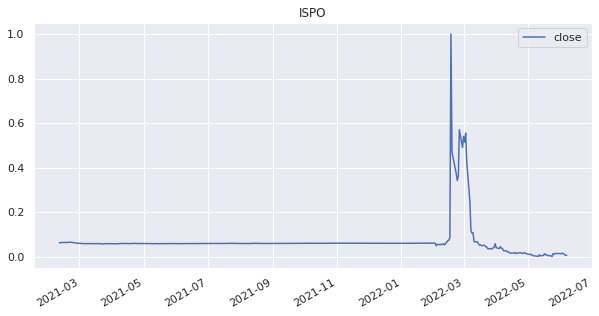

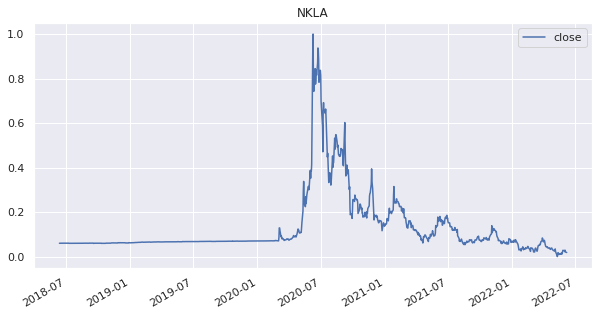

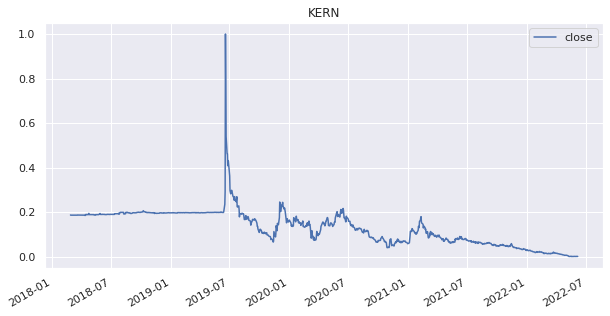

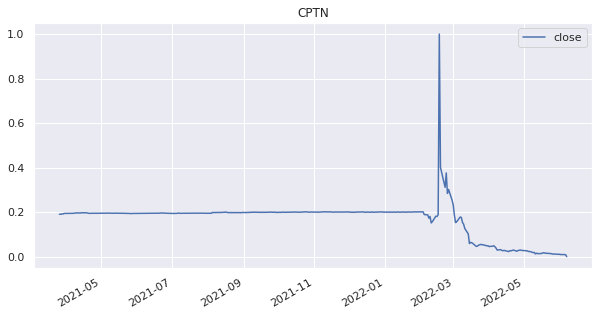

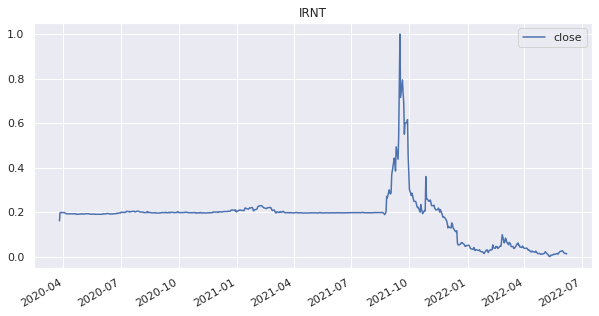

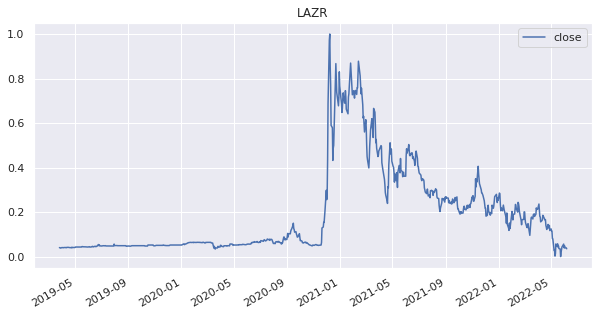

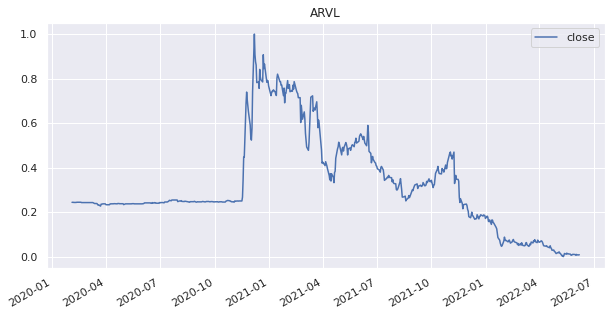

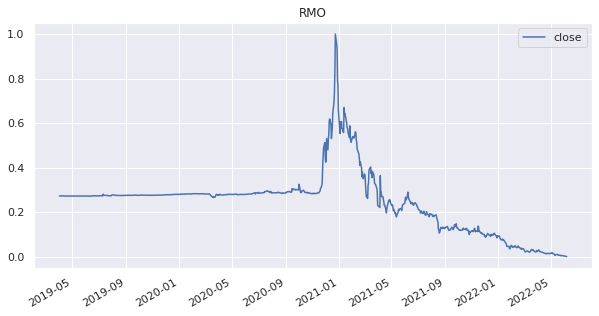

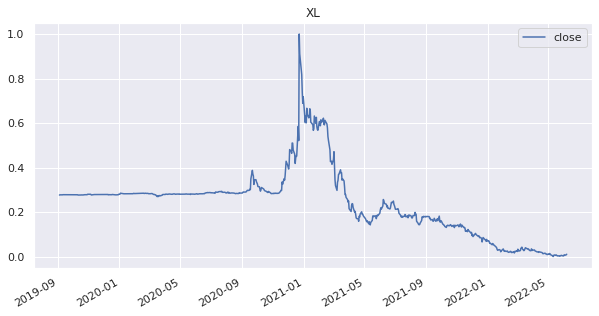

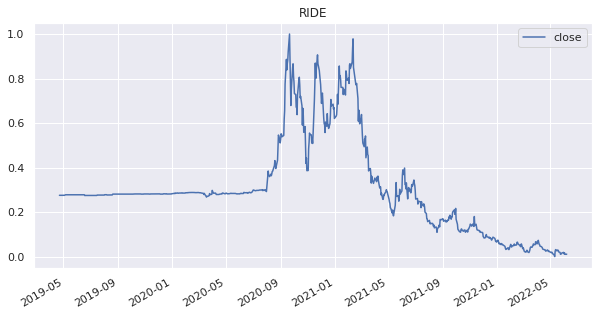

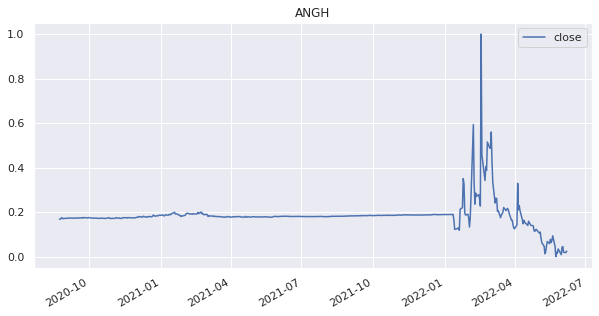

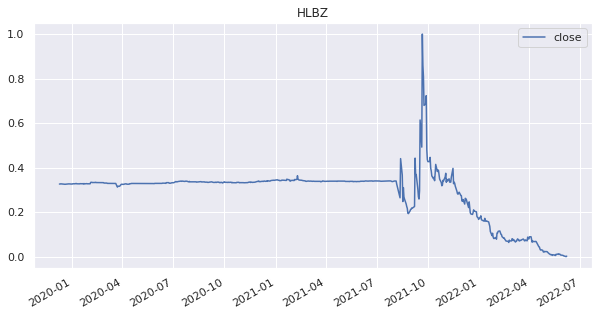

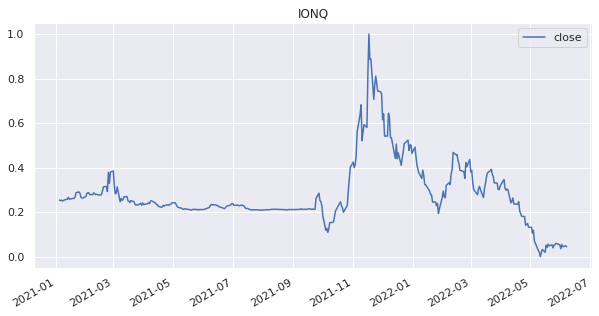

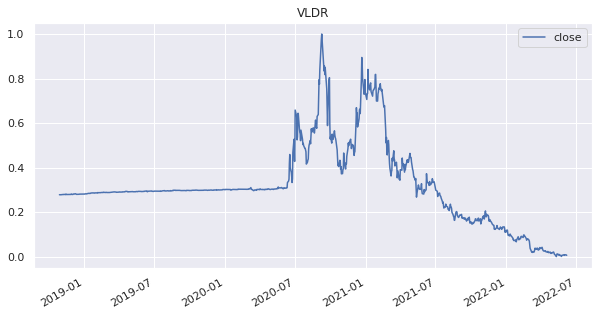

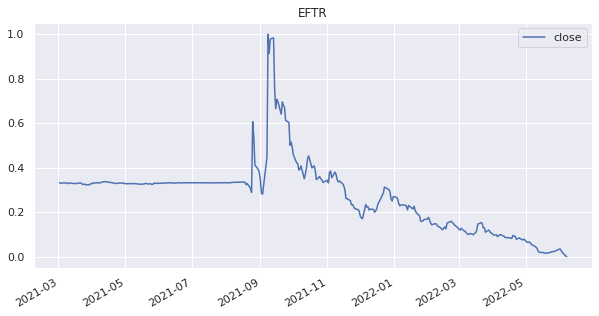

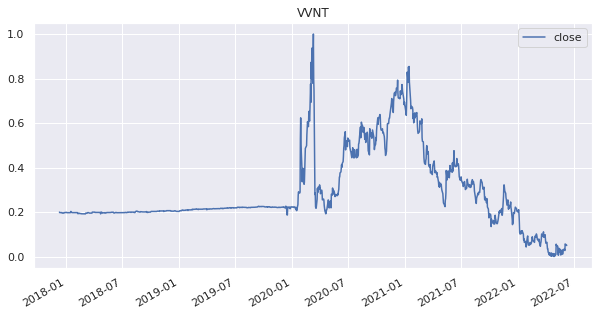

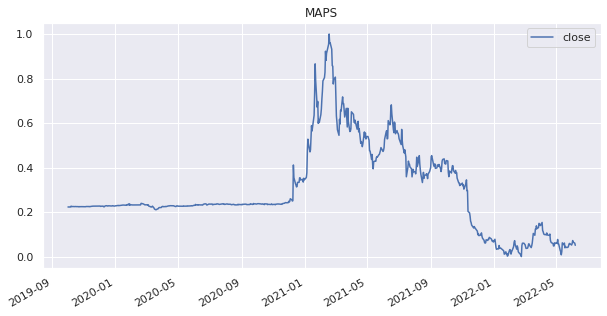

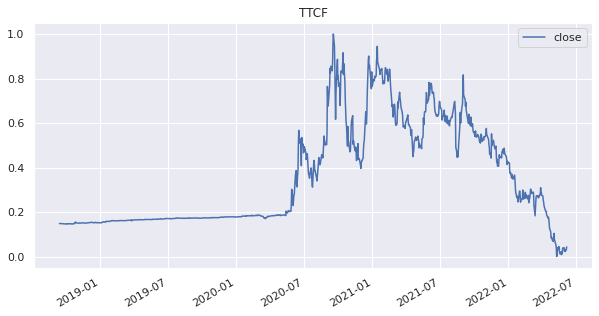

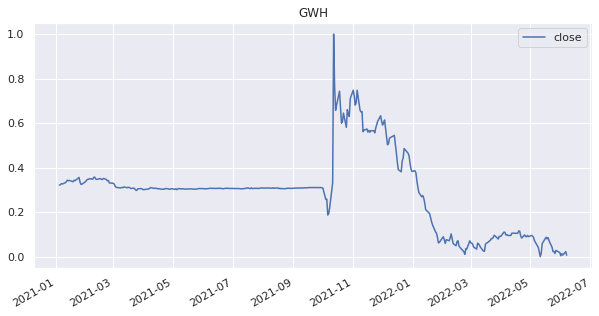

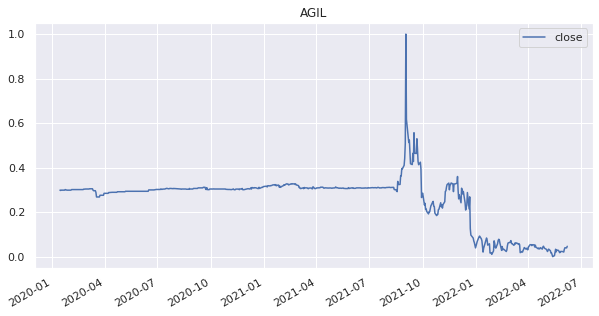

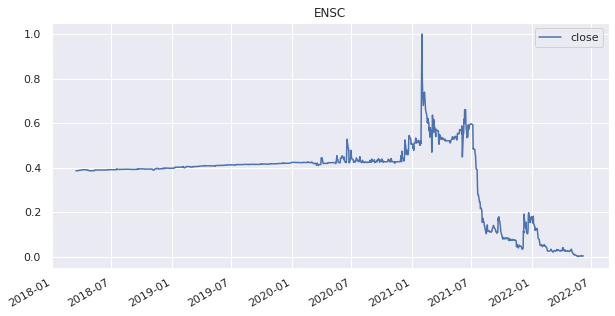

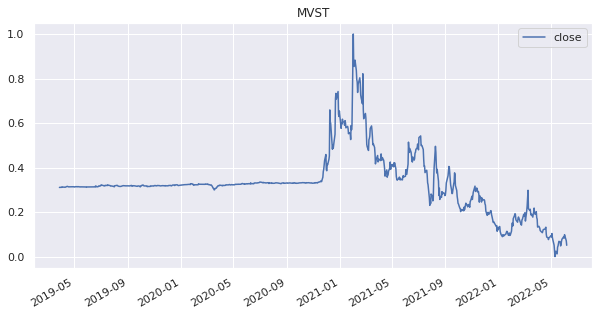

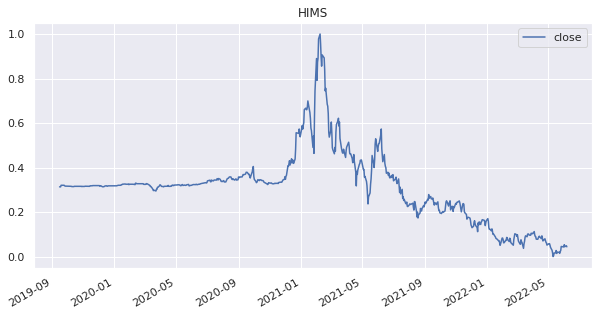

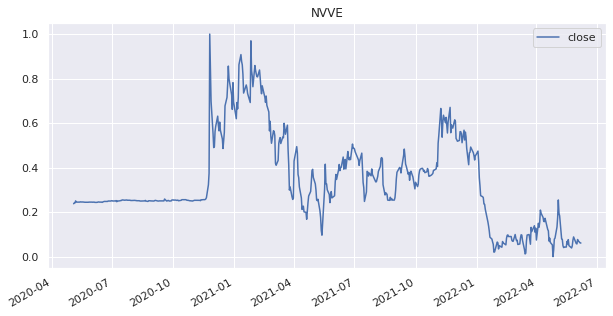

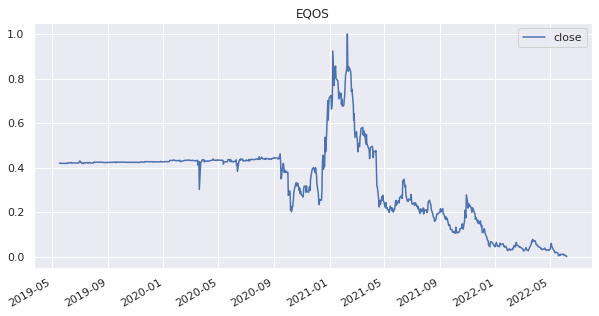

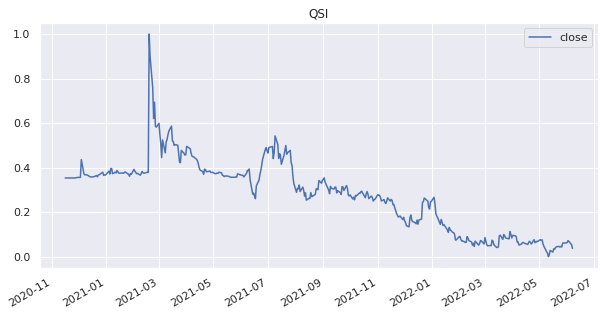

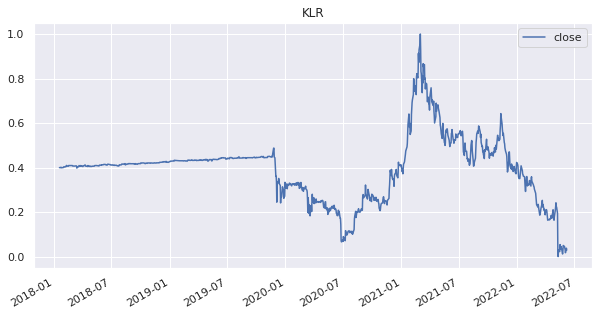

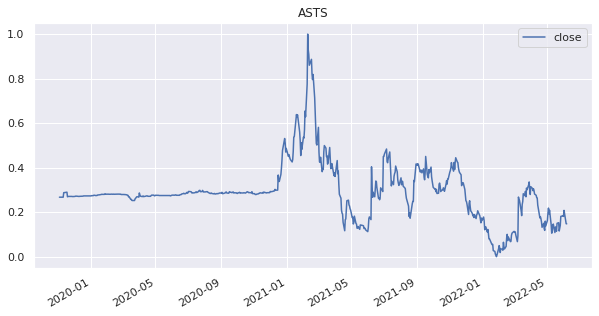

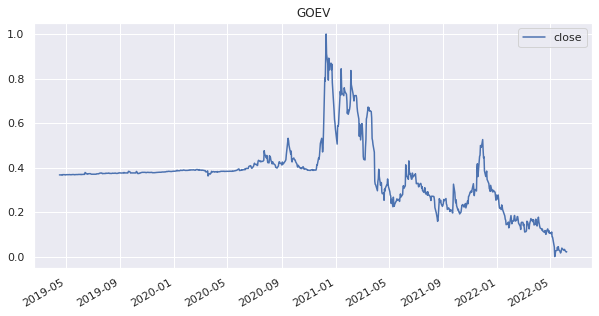

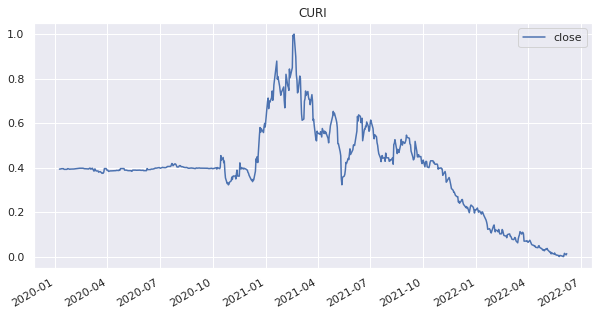

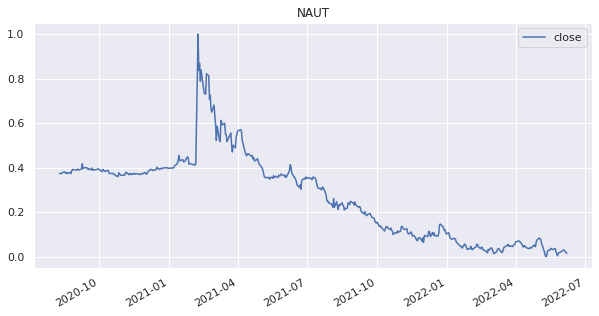

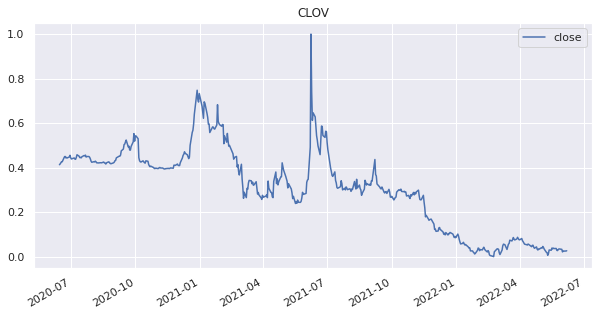

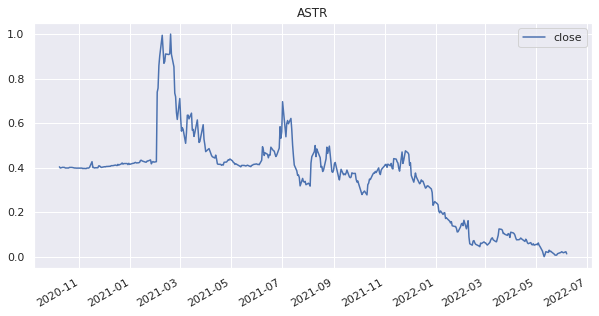

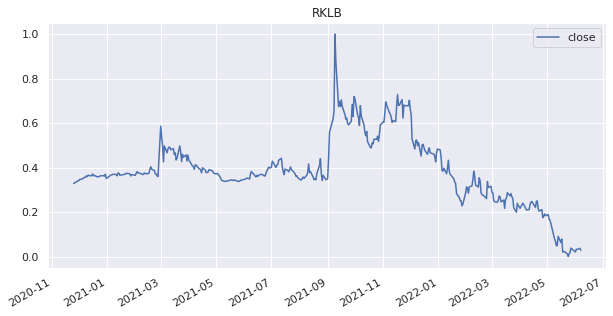

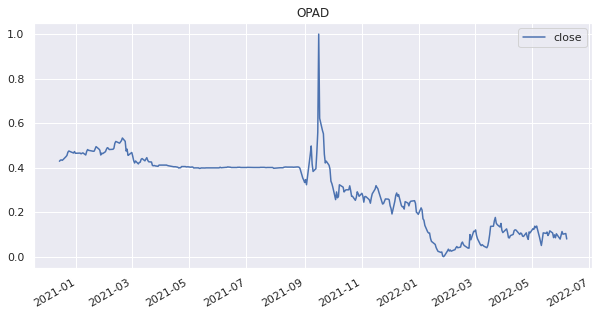

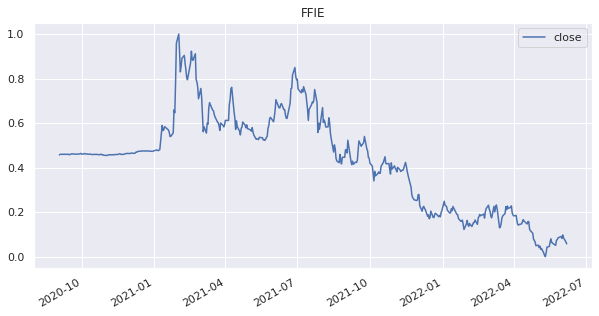

In [29]:
for x in train:
  ax = dfs[x]['scaled'][['close']].plot(figsize=(10,5), title=x)
  plt.show()

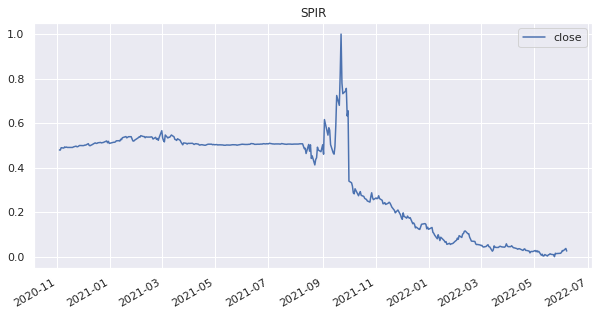

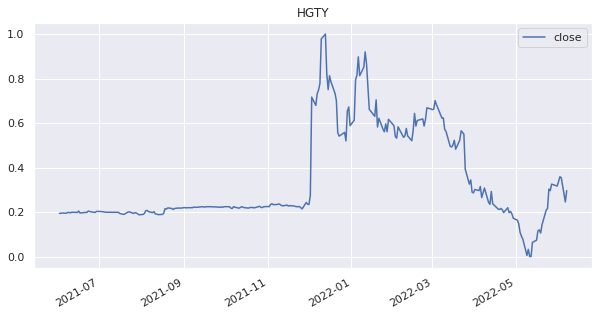

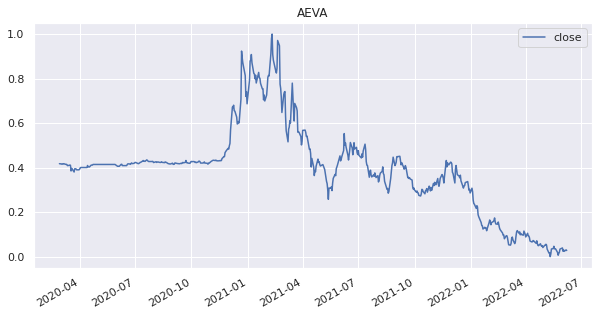

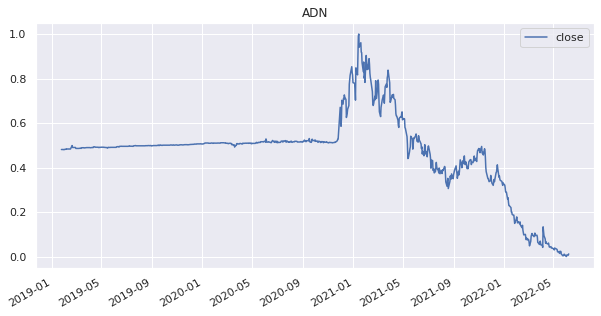

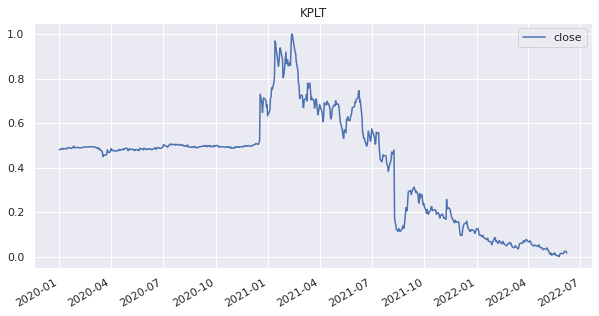

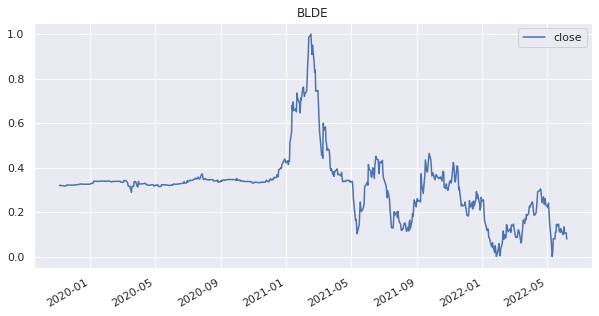

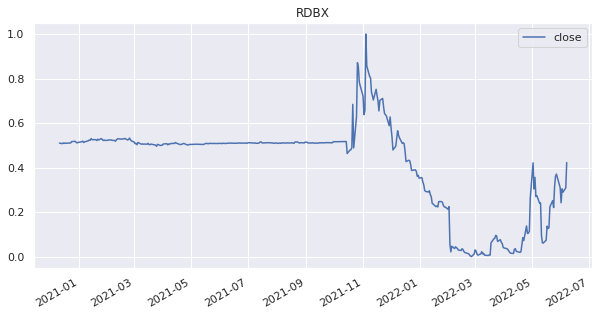

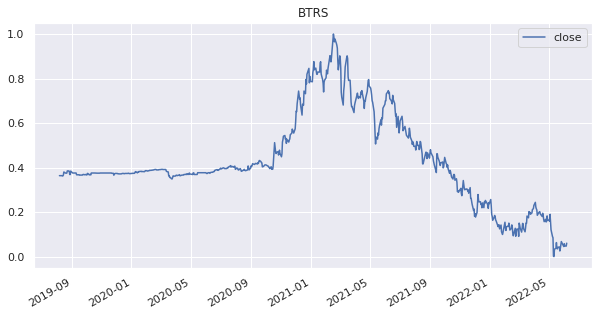

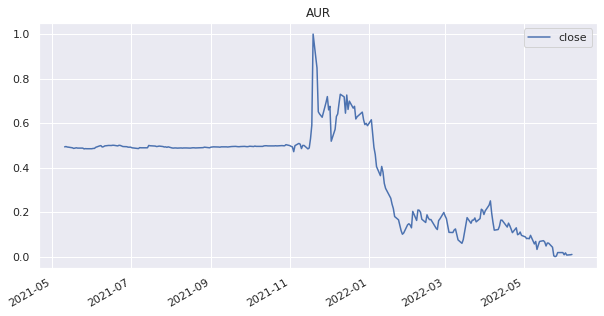

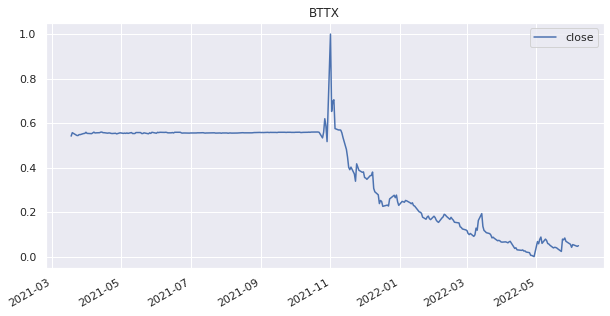

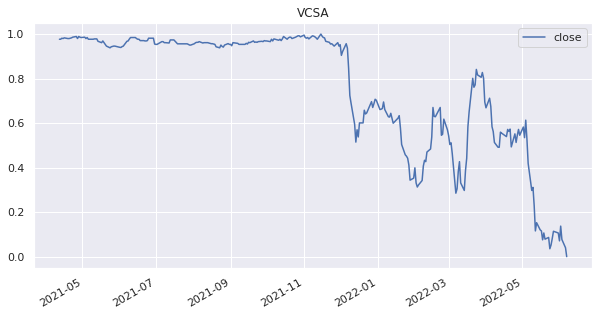

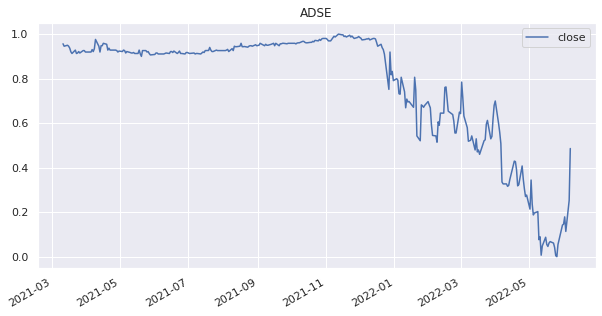

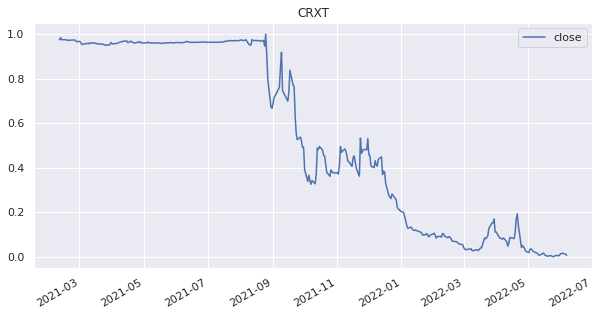

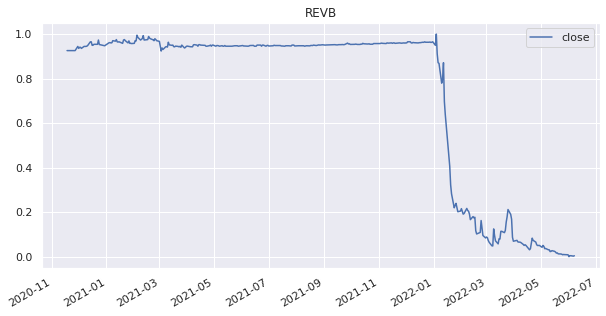

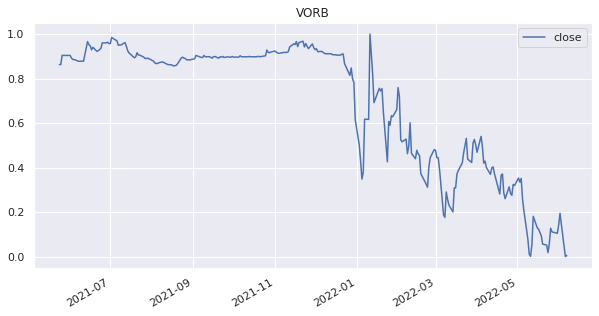

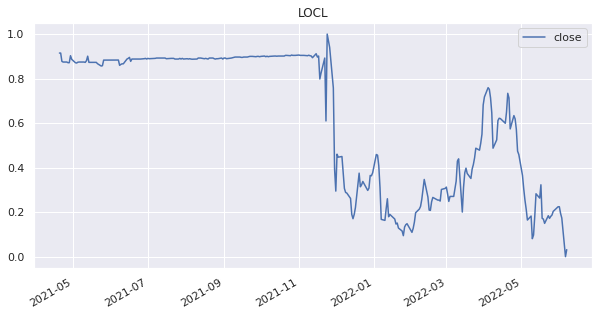

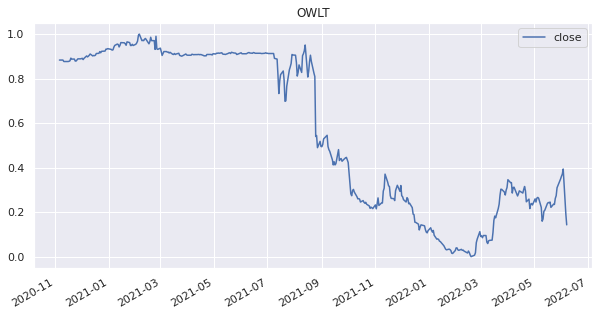

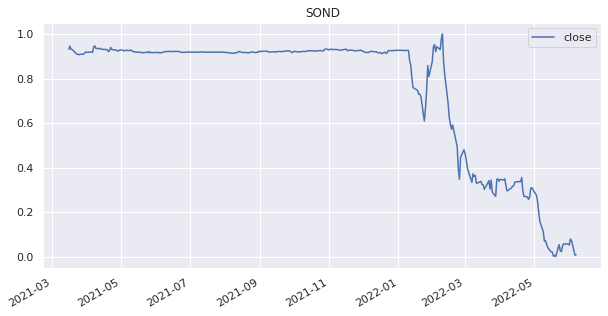

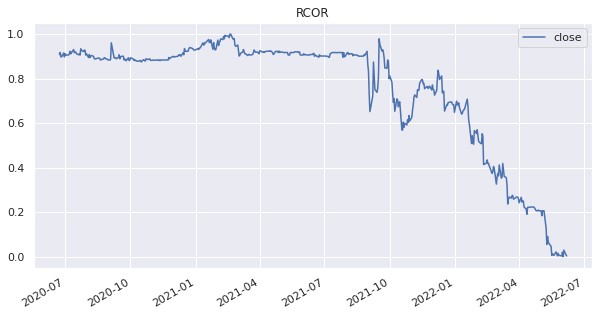

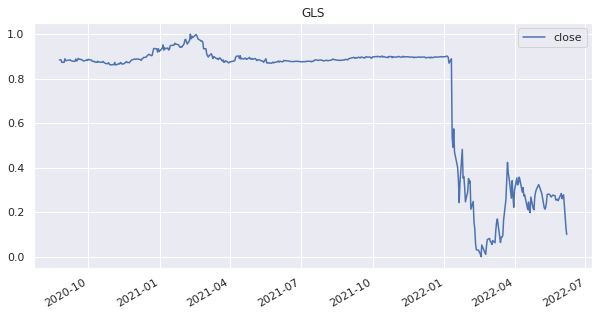

In [73]:
for x in test:
  ax = dfs[x]['scaled'][['close']].plot(figsize=(10,5), title=x)
  plt.show()

Each time we will feed the model X obseravation days and predict Y days
Current setup is 30 days input, 1 day output

In [74]:
observed_period = 30
# predicted_period = 4
# prepeare input/output vectors
for x in train + test:
  df = dfs[x]['scaled'].copy()
  daily_data = df[feature_cols].values # element per day
  train_features, labels = [], []
  for i in range(observed_period, df.index.size):
    train_features.append(daily_data[i-observed_period:i, :]) # x days, all features
    labels.append(daily_data[i, :]) # x output days labels

  dfs[x]['train_features'], dfs[x]['labels'] = np.array(train_features), np.array(labels)
  print(f'{x} shapes:')
  print("\ttrain input shape: ", dfs[x]['train_features'].shape)
  print("\ttrain output shape", dfs[x]['labels'].shape)

ISPO shapes:
	train input shape:  (304, 30, 1)
	train output shape (304, 1)
NKLA shapes:
	train input shape:  (975, 30, 1)
	train output shape (975, 1)
KERN shapes:
	train input shape:  (1048, 30, 1)
	train output shape (1048, 1)
CPTN shapes:
	train input shape:  (273, 30, 1)
	train output shape (273, 1)
IRNT shapes:
	train input shape:  (525, 30, 1)
	train output shape (525, 1)
LAZR shapes:
	train input shape:  (778, 30, 1)
	train output shape (778, 1)
ARVL shapes:
	train input shape:  (561, 30, 1)
	train output shape (561, 1)
RMO shapes:
	train input shape:  (773, 30, 1)
	train output shape (773, 1)
XL shapes:
	train input shape:  (666, 30, 1)
	train output shape (666, 1)
RIDE shapes:
	train input shape:  (760, 30, 1)
	train output shape (760, 1)
ANGH shapes:
	train input shape:  (421, 30, 1)
	train output shape (421, 1)
HLBZ shapes:
	train input shape:  (598, 30, 1)
	train output shape (598, 1)
IONQ shapes:
	train input shape:  (329, 30, 1)
	train output shape (329, 1)
VLDR shapes:


For plotting and validation we used the same data as for training but for better visualization we cut it 3 days after the price peak.

We drop some of the stocks that don't have enough data

In [75]:
# split the data around the price peak
c = []
from operator import index
for x in test:
  df = dfs[x]['scaled'].copy()
  df = df[:dfs[x]['max_price_date']+timedelta(days=5)]
  print(x, df.index.size)
  if not df.index.size < observed_period:
    dfs[x]['test'] = df.copy()
    test_data = df[feature_cols].values
    # print(test_data.shape)
    # break
    test_features = []
    for i in range(observed_period, df.index.size):
      test_features.append(test_data[i-observed_period:i, :]) # x days, all features
    dfs[x]['test_features'] = np.asarray(test_features)
    print(f'{x} shapes:')
    print("\ttest input shape: ", dfs[x]['test_features'].shape)
  else:
    c.append(x)
    dfs[x]['test'] = None
    dfs[x]['test_features'] = None
print(c)

SPIR 225
SPIR shapes:
	test input shape:  (195, 30, 1)
HGTY 140
HGTY shapes:
	test input shape:  (110, 30, 1)
AEVA 243
AEVA shapes:
	test input shape:  (213, 30, 1)
ADN 501
ADN shapes:
	test input shape:  (471, 30, 1)
KPLT 284
KPLT shapes:
	test input shape:  (254, 30, 1)
BLDE 324
BLDE shapes:
	test input shape:  (294, 30, 1)
RDBX 230
RDBX shapes:
	test input shape:  (200, 30, 1)
BTRS 388
BTRS shapes:
	test input shape:  (358, 30, 1)
AUR 139
AUR shapes:
	test input shape:  (109, 30, 1)
BTTX 163
BTTX shapes:
	test input shape:  (133, 30, 1)
VCSA 157
VCSA shapes:
	test input shape:  (127, 30, 1)
ADSE 176
ADSE shapes:
	test input shape:  (146, 30, 1)
CRXT 140
CRXT shapes:
	test input shape:  (110, 30, 1)
REVB 287
REVB shapes:
	test input shape:  (257, 30, 1)
VORB 165
VORB shapes:
	test input shape:  (135, 30, 1)
LOCL 156
LOCL shapes:
	test input shape:  (126, 30, 1)
OWLT 65
OWLT shapes:
	test input shape:  (35, 30, 1)
SOND 233
SOND shapes:
	test input shape:  (203, 30, 1)
RCOR 169
RCOR sh

Here we define the NN architecture. we used LSTM as it allows learning from multiple samples spread accross time, as we are dealing with time series dataset, this works well for us

In [32]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import losses

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(observed_period, len(feature_cols))))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

model.add(Dense(len(feature_cols)))
model.compile(optimizer = 'adam',
              loss = losses.MeanSquaredError(reduction='none')
              )

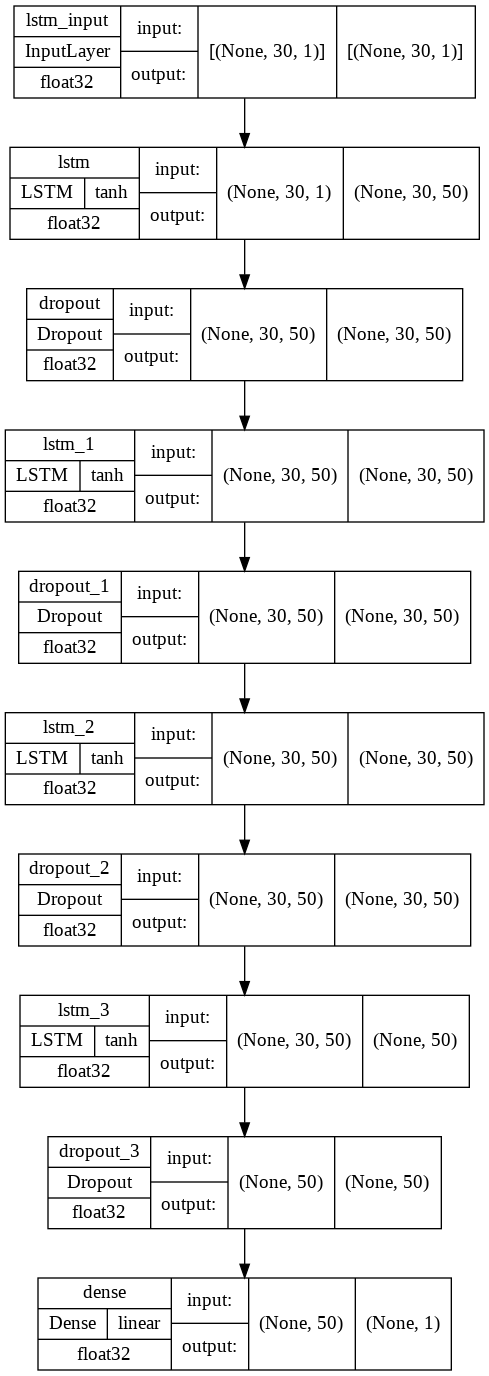

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
    show_layer_activations=True,
)

After the network is compiled we use every sample in out list of stocks to train it.
We feed a single network with examples of 286 of the stocks

In [35]:
drop_list = []
i = 1
for x in train:
  if dfs[x]['train_features'].size == 0:
    drop_list.append(x)
    i+=1
  else:
    print(f"fitting {x} ({i}/{len(train)})")
    model.fit(dfs[x]['train_features'],
              dfs[x]['labels'],
              epochs=100,
              batch_size=dfs[x]['train_features'].size,
              verbose=2)
    i+=1
print("droped: ", drop_list)

Streaming output truncated to the last 5000 lines.
1/1 - 0s - loss: 0.0014 - 311ms/epoch - 311ms/step
Epoch 14/100
1/1 - 0s - loss: 0.0015 - 309ms/epoch - 309ms/step
Epoch 15/100
1/1 - 0s - loss: 0.0015 - 305ms/epoch - 305ms/step
Epoch 16/100
1/1 - 0s - loss: 0.0014 - 294ms/epoch - 294ms/step
Epoch 17/100
1/1 - 0s - loss: 0.0015 - 302ms/epoch - 302ms/step
Epoch 18/100
1/1 - 0s - loss: 0.0016 - 312ms/epoch - 312ms/step
Epoch 19/100
1/1 - 0s - loss: 0.0013 - 312ms/epoch - 312ms/step
Epoch 20/100
1/1 - 0s - loss: 0.0015 - 312ms/epoch - 312ms/step
Epoch 21/100
1/1 - 0s - loss: 0.0014 - 325ms/epoch - 325ms/step
Epoch 22/100
1/1 - 0s - loss: 0.0013 - 305ms/epoch - 305ms/step
Epoch 23/100
1/1 - 0s - loss: 0.0013 - 316ms/epoch - 316ms/step
Epoch 24/100
1/1 - 0s - loss: 0.0013 - 311ms/epoch - 311ms/step
Epoch 25/100
1/1 - 0s - loss: 0.0013 - 308ms/epoch - 308ms/step
Epoch 26/100
1/1 - 0s - loss: 0.0015 - 310ms/epoch - 310ms/step
Epoch 27/100
1/1 - 0s - loss: 0.0013 - 303ms/epoch - 303ms/step
Ep

Here we look at the test data (cut off 3 days after max price)

We take 20 days sample from 20 days ago (-37 to -17 days before max price)

each time we predict one day, append it to the input, and drop one day off the end. 

then we feed the result back to the network for 20 iterations

the results are plotted bellow

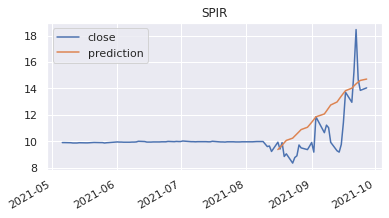

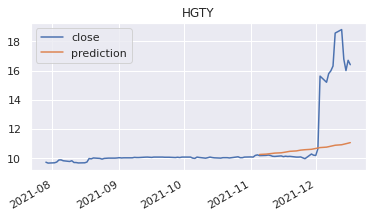

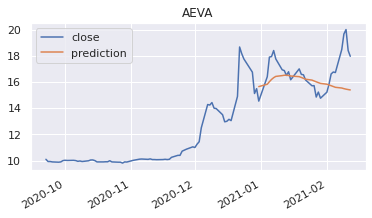

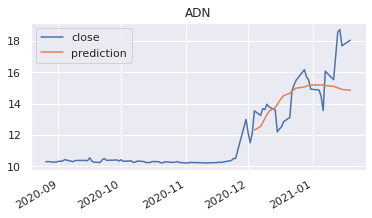

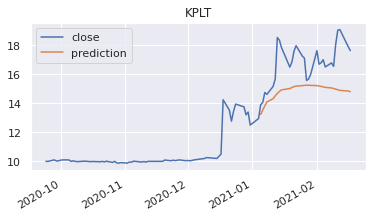

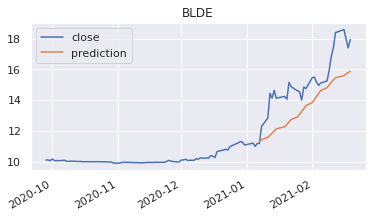

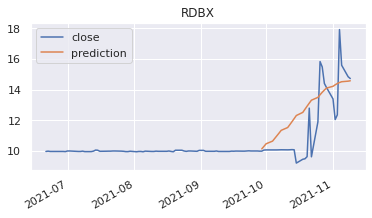

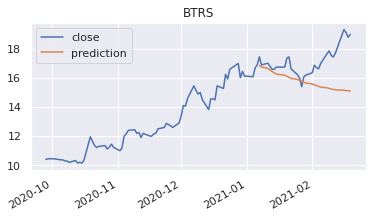

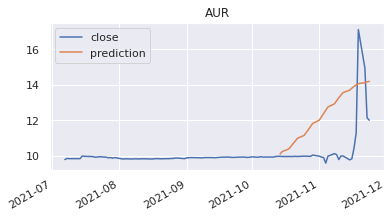

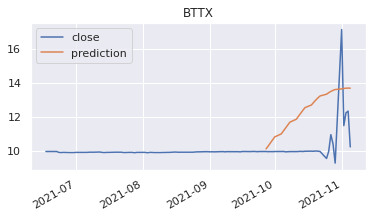

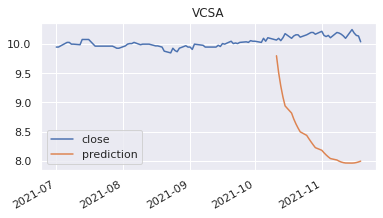

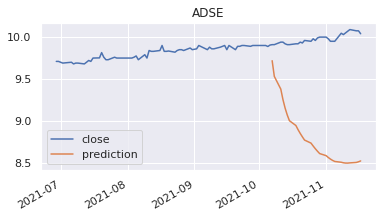

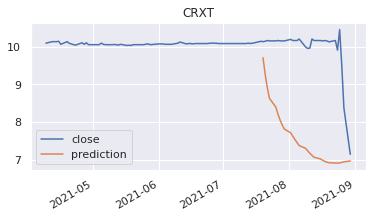

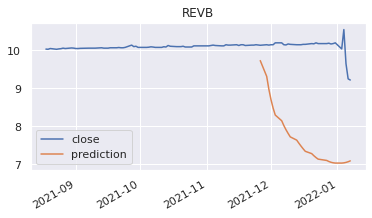

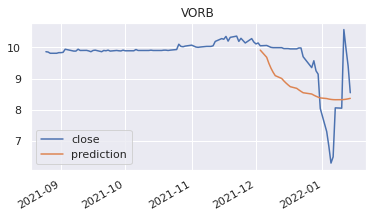

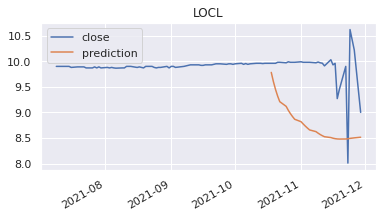

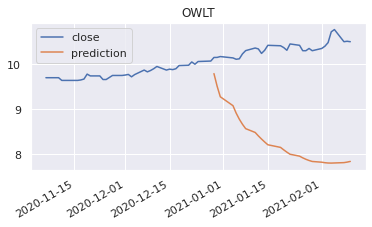

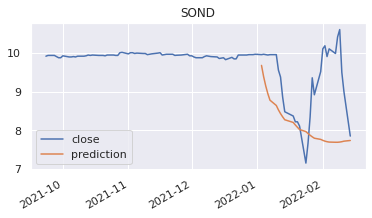

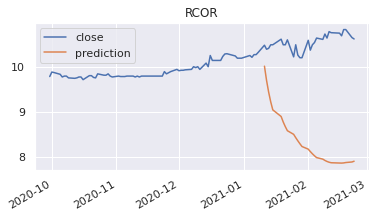

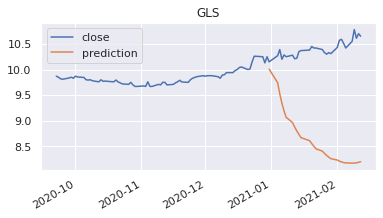

In [76]:
repeat = 30
pd.options.mode.chained_assignment = None
for x in test: #['MTTR', 'ENVX', 'CHPT', 'LCID', 'ISPO', 'IRNT', 'IONQ', 'FRGE']:
  if dfs[x]['test_features'] is not None:
    test_features = dfs[x]['test_features'][-repeat:-repeat+1]
    # print(test_features)
    if not test_features.size == 0:
      for i in range(repeat):
        predictions = model.predict(np.array(test_features))
        test_features = np.array([np.append(test_features[0], predictions, axis=0)[1:]])
      result = test_features[0][-repeat:]
      result_df = pd.DataFrame(result, columns=feature_cols)
      # display(ttt[feature_cols])
      result_df[feature_cols] = dfs[x]['scaler'].inverse_transform(result_df)
      # display(ttt[feature_cols])
      # break
      df = dfs[x]['test'].copy()
      df[feature_cols] = dfs[x]['scaler'].inverse_transform(df[feature_cols])
      df['prediction'] = np.nan
      df['prediction'][-repeat:] = result_df['close']
      # display(dfs[x]['train'][['prediction']])
      df[['close', 'prediction']].iloc[-100:].plot(figsize=(6,3), title=x)
      plt.show()
    # _tmp_df = dfs[x]['scaled'].copy()
    # _tmp_df['close'][-predicted_period*cnt:] = np.ravel(predictions.reshape(-1, 1))
    # _tmp_df[feature_cols] = dfs[x]['scaler'].inverse_transform(_tmp_df[feature_cols])
    # _tmp_df.close[:-predicted_period*cnt] = np.full(_tmp_df.index.size - predicted_period*cnt, np.nan)
    # _tmp_df['prediction'] = _tmp_df['close']
    # dfs[x]['train']['prediction'] = _tmp_df['prediction']
    # dfs[x]['train'][['close', 'prediction']].iloc[(-predicted_period-observed_period)*cnt:].plot(figsize=(6,3),title=x)
    # plt.show()

# Conclusion:
Current setup predicts the price of the stock in 20 days bellow actual price.

This result is good as it is safer then predicting a higher than actual price.

We noticed the result seems to be off in some of the cases although almost in all cases the price delta was not that big in this particular examples.

Predicting one day and and feeding it as input to the network gives better results then predicting multiple days in one shot when using LSTM

When we tried to use multiple features with current network setup, the results were worse thus we decided to continue with closign price only

in the plots above you can clearly see how for the least profitable stocks (although not included in the training of the model) the overall trend is decreasing over time while with the profitable SPACs the trend is increasing

that trend can be used as a factor for decision making upon investment to maximize returns.